In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings 
import pandas as pd
import folium
import urllib.request
from zipfile import ZipFile
from io import BytesIO
import folium

warnings.filterwarnings("ignore")

In [3]:
# download 

shape_file_url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/POA_2021_AUST_GDA2020_SHP.zip"
shape_file_directory = "../data/POA_2021_AUST_GDA2020_SHP"



# read the zip file, unzip the folder and export files in censusData folder
with urllib.request.urlopen(shape_file_url) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall(shape_file_directory)

In [4]:
regions = gpd.GeoDataFrame.from_file(
    "../data/POA_2021_AUST_GDA2020_SHP/POA_2021_AUST_GDA2020.shp"
)

In [5]:
regions = regions[regions["geometry"] != None]
regions['postcode'] = regions['POA_CODE21'].astype(int)

<AxesSubplot:>

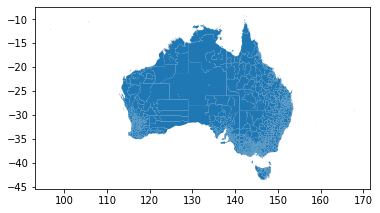

In [6]:
regions.plot()

In [9]:
trans_df = pd.concat([
    pd.read_parquet("../data/tables/transactions_20210228_20210827_snapshot"),
    pd.read_parquet("../data/tables/transactions_20210828_20220227_snapshot")])

In [10]:
trans_df = pd.merge(
    trans_df,
    pd.read_parquet("../data/tables/consumer_user_details.parquet"),
    on="user_id"
)

In [11]:
consumer_df = pd.read_csv("../data/tables/tbl_consumer.csv",sep="|")

In [12]:
con_postcode_count = consumer_df.groupby("postcode")["name"].count().reset_index().rename(columns={"name":"count"})

In [13]:
trans_df

,user_id,merchant_abn,dollar_value,order_id,order_datetime,consumer_id
0,1,28000487688,133.226894,0c37b3f7-c7f1-48cb-bcc7-0a58e76608ea,2021-02-28,1195503
1,1,83690644458,30.441348,40a2ff69-ea34-4657-8429-df7ca957d6a1,2021-02-28,1195503
2,1,96680767841,301.677498,5b6c059c-6831-4710-a2ff-76e265b4a509,2021-03-02,1195503
3,1,49891706470,5.904951,39e028ec-1663-4aff-a341-a9ad882d68d7,2021-03-04,1195503
4,1,62403837535,18.135592,316b9dec-1140-4ef9-bbf3-810694eb7eda,2021-03-06,1195503
...,...,...,...,...,...,...
8151367,7770,52342208808,110.284431,14a9e949-6429-44d2-baaa-d573dada0dac,2022-02-22,1079450
8151368,7770,82065156333,2.795985,48f25b8a-73ef-4f81-93df-e7c58c0eff83,2022-02-23,1079450
8151369,7770,30623214058,97.476905,e5e940d5-a068-46f1-bf12-bb8a97275abb,2022-02-26,1079450
8151370,7770,98314397036,1.012714,bc7e8355-afea-4914-be0f-623e54159f0f,2022-02-27,1079450


In [14]:
trans_postcode_count = pd.merge(
    trans_df.groupby("consumer_id")["user_id"].count().reset_index().rename(columns={"user_id":"count"}),
    consumer_df[["consumer_id","postcode"]],
    on="consumer_id"
).groupby("postcode")["count"].sum().reset_index()

<AxesSubplot:>

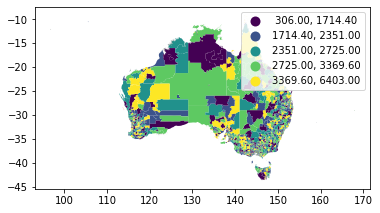

In [17]:
pd.merge(
    regions[['postcode','geometry']],
    trans_postcode_count,
    on="postcode"
).plot(
    column = 'count',
    scheme = 'quantiles',
    legend = True
)

In [19]:
trans_postcode_count

,postcode,count
0,200,1347
1,800,3777
2,801,2718
3,804,2403
4,810,3343
...,...,...
3160,9013,2702
3161,9015,2326
3162,9464,3036
3163,9726,2026


In [ ]:
tip_proportion = folium.Map(location=[-37.81, 144.95], tiles="Stamen Terrain", zoom_start=10, control = True)

tip_proportion = tip_proportion.add_child(folium.Choropleth(geo_data=regions, data = trans_postcode_count, 
                                            columns = ['postcode', 'count'],
                                            key_on = 'properties.postcode',
                                            fill_color = 'OrRd', name='choropleth'))



tip_proportion.save('../plots/melbourne_postcode_average_transaction.html')
tip_proportion